# Pneuomnia classification - Notebook for experimention

## Imports

In [13]:
# System imports
import os
from pathlib import Path
# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
import seaborn as sn
import cv2
# Pytorch imports
import torch 
import torch.nn as nn
import torch.nn.functional as F
# Vision imports
import torchvision
import torchvision.transforms as transforms
# Random
import random
# TQDM
import tqdm

# setting up device agnostics
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# Setting number of works and directories for data
NUM_WORKERS = os.cpu_count()
TRAIN_DIR = "../Data/train/"
TEST_DIR = "../Data/test/"
DATA_DIR = "../Data"




TRAINING_MODEL_NUMBER = 2
SAVE_MODEL = True
LOAD_ALL_MODELS = True


## The task

We wish to create a Neural network classifer to be able to classify pnuomnia from x-ray images of patients chests.

<b>The data (from [here](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)) </b>

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Visulising data

First we are going to check how many of each sample we have in our training and test data, we will do that by getting the number of files in each class file.

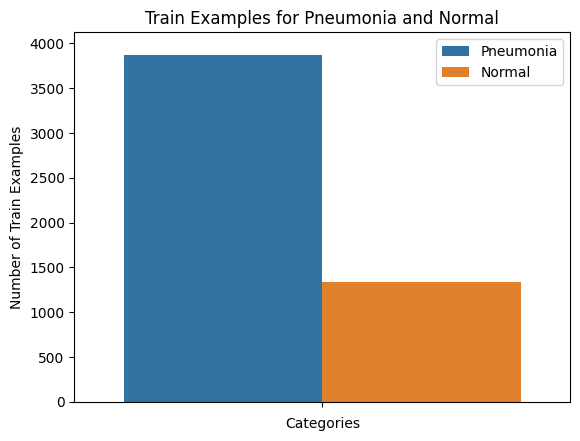

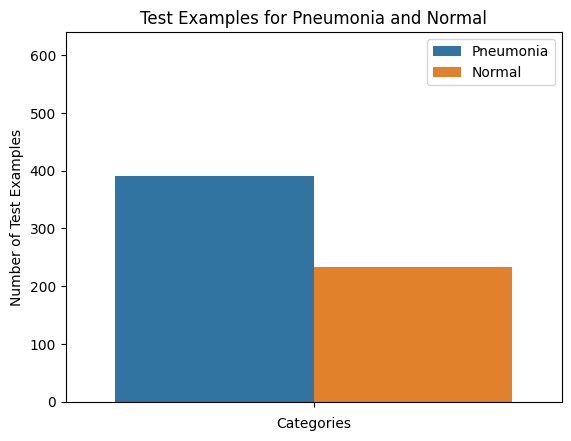

In [14]:
def class_numbers_and_plot(
                            DIR : str, 
                            train : bool = True
                            ) -> None:
    '''
    Function for finding the number of examples of each class
    Plots bar chart of the examples of each class in a set.
    Args:
        DIR (str) : DIR of training/test data
        train (bool) : 
    '''
    # Title of plots
    title = "Train" if train else "Test"
    # Get files in the directory
    pneumonia_files = os.listdir(DIR + "PNEUMONIA")
    normal_files = os.listdir(DIR + "NORMAL")

    # Get length of the number of files
    num_pneumonia = len(pneumonia_files)
    num_normal = len(normal_files)

    # Catorgory labels
    categories = ['Pneumonia', 'Normal']
    counts = [num_pneumonia, num_normal]
  
    # Create figure, plot bar chart and set label titles
    plt.figure()
    sn.barplot( y=  counts, hue = categories)
    plt.xlabel('Categories')
    plt.ylabel(f'Number of {title} Examples')
    plt.title(f'{title} Examples for Pneumonia and Normal')
    plt.ylim(0, max(counts) + 250)  
    plt.show()

class_numbers_and_plot(TRAIN_DIR)
class_numbers_and_plot(TEST_DIR, train = False)

Here we see that there are many more Pneumonia examples then normal examples, this will lead to a performance decrease from the bias towards Pneumonia classifcaiton of which we will have to deal with later and acts as a way to improve the performance of our base model.


<b>Improvement potential </b> One way we will be able to improve the classification potential of our model is by implementing some sort of measure (data augmentation/balancing) to be able to balance the training set.
 

Next will will just plot 5 examples of each in a grey scale form, this helps us see how big the visual difference is in between the classes(if there is any).

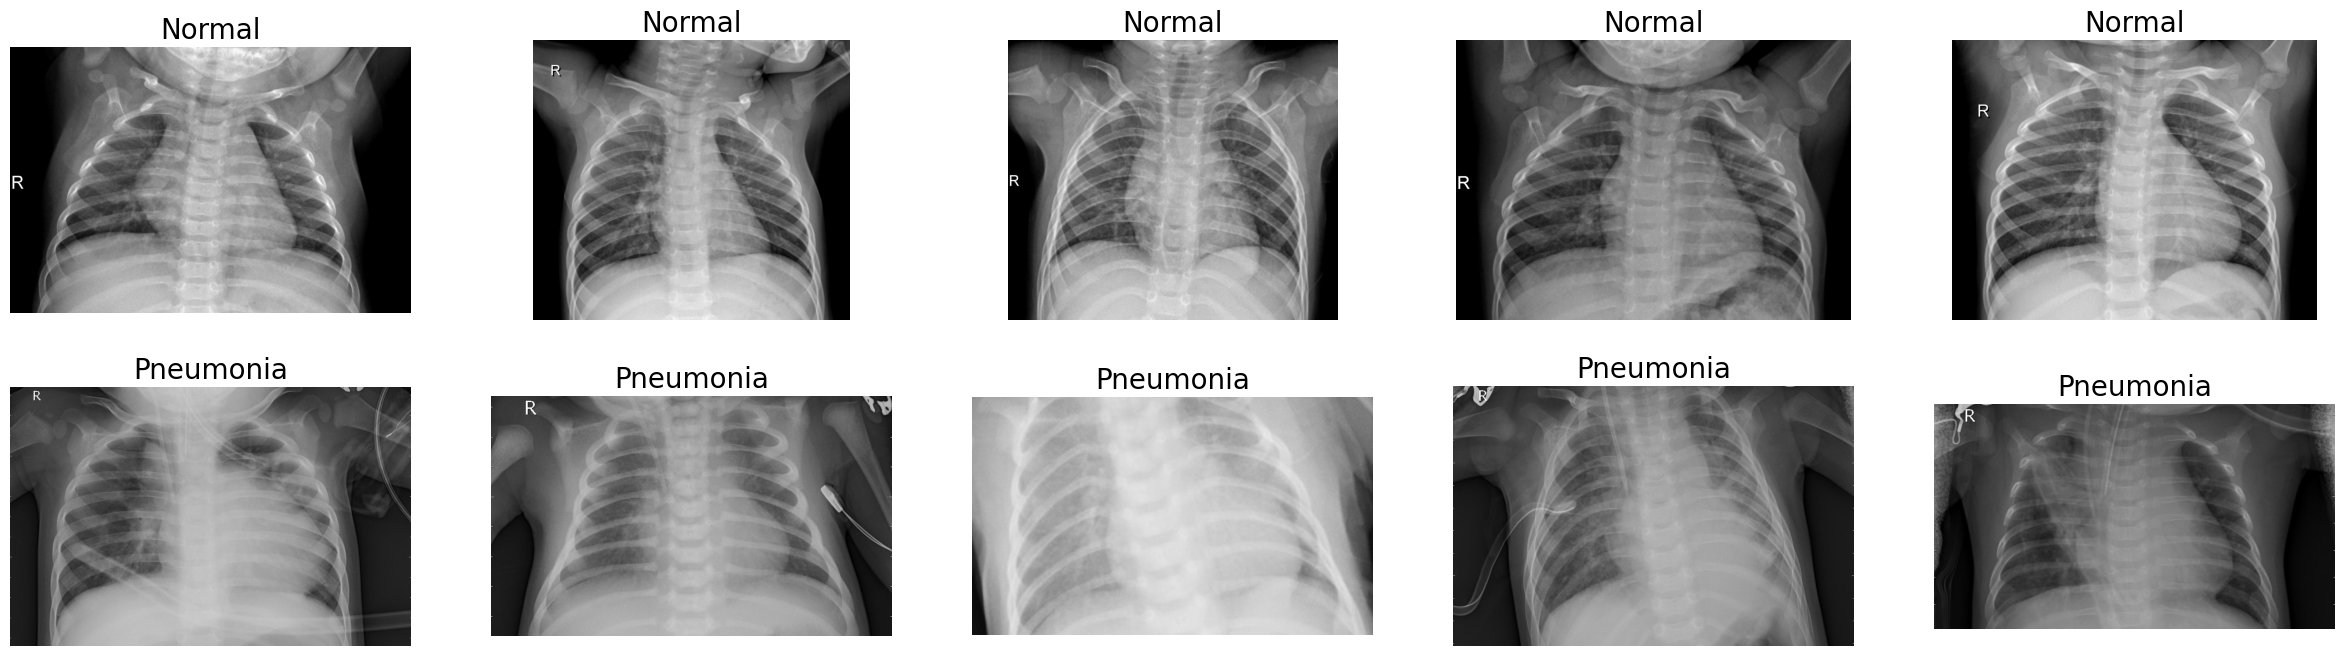

In [15]:
def plot_random_samples(n_examples : int, 
                 data_dir :str = DATA_DIR
                 ) -> None:  
    '''
    Function to pick n random samples of each class (2), plots examples in grey scale.
    Args:
        n_example (int) : number of examples for each class
        data_data (str) default : DATA_DIR  : directory of the DATA
    '''
    # Pick n random samples from each class
    rand_samples = random.sample([os.path.join(DATA_DIR+'/train/NORMAL', filename) 
                              for filename in os.listdir(DATA_DIR+'/train/NORMAL')], 5) + \
                random.sample([os.path.join(DATA_DIR+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(DATA_DIR+'/train/PNEUMONIA')], 5)
    
    # Create figure and axis
    fig, ax = plt.subplots(nrows=2, ncols = n_examples, figsize=(30,8))
    # Loop through
    for i in range(n_examples * 2):
        # Use opencv to covert image to grey scale
        image = cv2.cvtColor(imread(rand_samples[i]), cv2.COLOR_BGR2RGB)
        # Plot stuff
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')


plot_random_samples(5)

## Setting up dataloaders

Before we set our models up, we will first create a function to generate our training and test data loaders and write this to a file in Scripts for use later on.

Creating the data loader will take the following arguments 
* train_dir - dir pointing to training data
* test_dir - dir pointing to test data
* transform - transformation to apply to data
* batch_size - size of batches in the data loader
* num_workers - amount of cpus to use loading data

In [16]:
#%%writefile ../Scripts/data_setup.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def create_dataloaders(
    train_dir : str,
    test_dir : str,
    transform : transforms.Compose,
    batch_size : int,
    num_workers : int
) -> list[DataLoader, DataLoader]:
    '''
    Function for creating dataloaders
    Args:
        train_dir (str) : dir of training data
        test_dir (str) : dir of test data
        transform (transforms.Compose) : transform to perform on data
        batch_size (int) : Number of samples per batch 
        num_workers (int) : number of workers per dataloader
    '''

    # Using Imagefolder to load images
    # Images in seperate folders, one folder for each label
    train_data = datasets.ImageFolder(root = train_dir, 
                                      transform = transform
                                      )
    test_data = datasets.ImageFolder(root = test_dir, 
                                     transform = transform
                                     )

    # Load data into DataLoaders
    train_dataloader = DataLoader(train_data, 
                                  batch_size=batch_size, 
                                  shuffle = True, 
                                  num_workers = num_workers,
                                  pin_memory = True # Pin memory is use to allow easier transfer to gpu
                                  )
    test_dataloader = DataLoader(test_data, 
                                 batch_size=batch_size, 
                                 shuffle = True, 
                                 num_workers = num_workers, 
                                 pin_memory = True
                                 )

    return train_dataloader, test_dataloader

## Creating training and testing functions

We will now create useful functions for training and evaluating our model.

These will be in the form of 
* train_step - an epoche in training
* test_step - an "epoche" in testing
* train_model  - to train the whole model

In [20]:
#%%writefile ../Scripts/engine.py
# Importing again just to write to file
import torch.nn as nn
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import f1_score, accuracy_score

def train_step(
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device = DEVICE
               ) -> Tuple[float, float]:
  """
  Trains a PyTorch model for a single epoch.
  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader object.
    loss_fn: A PyTorch loss function.
    optimizer: A PyTorch optimizer.
    device: A target device to compute on (e.g. "cuda" or "cpu").
  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(
        model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


def train_model(
        train_data_loader : DataLoader,
        test_data_loader : DataLoader,
        model : nn.Module,
        loss_funcion : nn.Module ,
        epoches : int = 10,
        optim_func : torch.optim = torch.optim.Adam,
        learn_rate : float = 0.001,
        device = DEVICE,
        plot_loss_rates : bool = True
        ) -> torch.nn.Module:
    '''
    Function for fitting a model to a data
    '''
    torch.cuda.empty_cache()

    optimiser = optim_func(model.parameters(), learn_rate)

    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
   }

    train_losses = []
    test_losses = []

    for epoch in range(epoches):
        # Put model in train mode
        train_loss, train_acc = train_step(
           model,
           train_data_loader,
           loss_funcion,
           optimiser,
           device
          )
        test_loss, test_acc = test_step(
           model,
           test_data_loader,
           loss_funcion,
           device
            ) 
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
          )
    if plot_loss_rates:
      plt.figure(figsize=(8,6))
      plt.plot(range(epoches), train_losses)
      plt.plot(range(epoches), test_losses)
      plt.show()


    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
   

def evalutation_model(
      model : nn.Module,
      evaluation_data : DataLoader,
      loss_fn : nn,
      device = DEVICE,
      ):
    '''
    Function for model evalutation, should of made it work with test_step but doesn't matter too much.
    Args:

    Returns:
    '''
    
    true_labels = []
    predicted_labels = []
    total_loss = 0
    correct = 0
    total = 0
    model.eval().to(device)

    with torch.no_grad():
        for inputs, labels in evaluation_data:

            inputs, labels = inputs.to(device), labels.to(device)          

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            total_loss += loss.item() 

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = total_loss / len(evaluation_data)
    epoch_accuracy = correct / total
    print(f1_score(true_labels, predicted_labels))

    return epoch_loss, epoch_accuracy, true_labels, predicted_labels
    

## How will we evaluate our models ? 

We will evaluate our models through the following metrics
* f1score - unbalanced dataset
* accuracy - still a good measure, especially later when we go into data augmentation
* confusion matrix - visulising the error
* validation set - splitting training data randomly into training and validation set
* Ideally repeat - we would ideally repeat each model training like 5 times to account for randomness, but I don't want to have to take a nap training each model.

## Model 1 - A simple linear model

In [18]:
class PnuomniaSimpleFFv1(nn.Module):
    def __init__(self):
        super(PnuomniaSimpleFFv1, self).__init__()
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.linear(x)

cuda
Epoch: 1 | train_loss: 0.6368 | train_acc: 0.8228 | test_loss: 0.3458 | test_acc: 0.8479
Epoch: 2 | train_loss: 0.1814 | train_acc: 0.9324 | test_loss: 0.7847 | test_acc: 0.7078
Epoch: 3 | train_loss: 0.1567 | train_acc: 0.9426 | test_loss: 0.6126 | test_acc: 0.7589
Epoch: 4 | train_loss: 0.1252 | train_acc: 0.9514 | test_loss: 0.7707 | test_acc: 0.7297
Epoch: 5 | train_loss: 0.1472 | train_acc: 0.9438 | test_loss: 0.9180 | test_acc: 0.7234


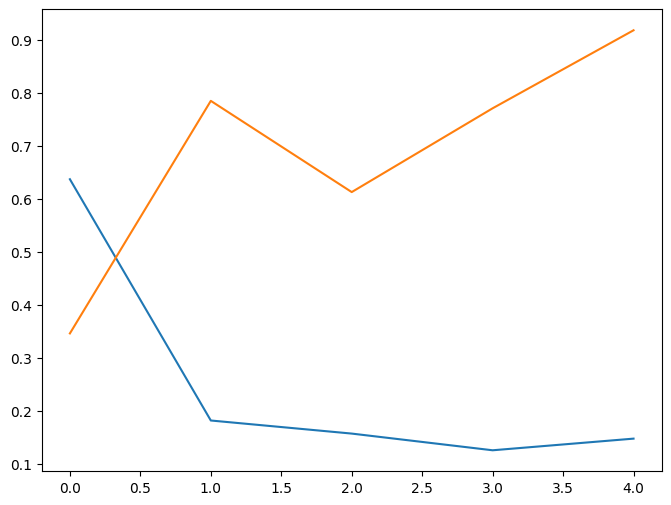

In [21]:
TRAINING_MODEL_NUMBER = 1
if TRAINING_MODEL_NUMBER == 1:

    transform = transforms.Compose(
        (
    transforms.Resize((56, 56)),
    transforms.ToTensor())
    )
    train_data, test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, transform, 64, NUM_WORKERS)
    print(DEVICE)
    modelv1 = PnuomniaSimpleFFv1()
    modelv1.to(DEVICE)


    loss_func = torch.nn.CrossEntropyLoss()
    train_model(train_data,
                test_data,                              
                modelv1,
                loss_func,
                epoches = 5
                )
    
    torch.save(modelv1.state_dict(), f'../Models/model_v{TRAINING_MODEL_NUMBER}_weights.pth')
    evalutation_model(modelv1, test_data, loss_func)
elif LOAD_ALL_MODELS: 
    try:
        transform = transforms.Compose(
                                    (
                                transforms.Resize((56, 56)),
                                transforms.ToTensor())
                                )
        loss_func = torch.nn.CrossEntropyLoss()
        train_data, test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, transform, 64, NUM_WORKERS)
        modelv1 = PnuomniaSimpleFFv1()
        modelv1.load_state_dict(torch.load('../Models/model_v1_weights.pth'))
        evalutation_model(modelv1, test_data, loss_func)
    except:
        print("Failed to load model")



TRAINING_MODEL_NUMBER = 2

## Model 2 - CenterCrop

Before making a more complex model we will first look at improving how are images are transformed - first we will centercrop the image helping with resolution issues we saw when visulising the images earlier, for this model everything else is the same.

In [ ]:
if TRAINING_MODEL_NUMBER == 2:

    transform = transforms.Compose(
        (
    transforms.Resize((56, 56)),
    transforms.CenterCrop((56, 56)),
    transforms.ToTensor())
    )
    train_data, test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, transform, 64, NUM_WORKERS)
    print(DEVICE)
    modelv2 = PnuomniaSimpleFFv1()
    modelv2.to(DEVICE)


    loss_func_2 = torch.nn.CrossEntropyLoss()
    train_loss_history, val_loss_history = train_model(train_data,
                                                        test_data,                              
                                                        modelv2,
                                                        loss_func_2,
                                                        epoches = 5
                                                        )
    
    torch.save(modelv2.state_dict(), f'../Models/model_v{TRAINING_MODEL_NUMBER}_weights.pth')
    evalutation_model(modelv1, test_data, loss_func)
elif LOAD_ALL_MODELS: 
    try:
        transform = transforms.Compose(
                                    (
                                transforms.Resize((56, 56)),
                                transforms.ToTensor())
                                )
        loss_func = torch.nn.CrossEntropyLoss()
        train_data, test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, transform, 64, NUM_WORKERS)
        modelv2 = PnuomniaSimpleFFv1()
        modelv2.load_state_dict(torch.load('../Models/model_v2_weights.pth'))
        evalutation_model(modelv1, test_data, loss_func)
    except:
        print("Failed to load model")


cuda
Epoch: 1 | train_loss: 0.7148 | train_acc: 0.7464 | test_loss: 0.4417 | test_acc: 0.7745
Epoch: 2 | train_loss: 0.2609 | train_acc: 0.8921 | test_loss: 0.6404 | test_acc: 0.7135
Epoch: 3 | train_loss: 0.1718 | train_acc: 0.9352 | test_loss: 0.3467 | test_acc: 0.8307
Epoch: 4 | train_loss: 0.1488 | train_acc: 0.9417 | test_loss: 0.7579 | test_acc: 0.7297
